In [1]:
#import function
import stereo2
#import basic module
import os
import time
from ximea import xiapi
import cv2
import time
import numpy as np
import pandas as pd
from scipy import linalg

c:\Users\kawaw\anaconda3\envs\kawawaki\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\kawaw\anaconda3\envs\kawawaki\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\kawaw\anaconda3\envs\kawawaki\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Calibration

In [ ]:
SRC = r'C:\Users\kawaw\utilities\calibration\20231208\640' #320_320
leftSrc = os.path.join(SRC,"left")
numLeft = len([f for f in os.listdir(leftSrc) if os.path.isfile(os.path.join(leftSrc, f))])
rightSrc = os.path.join(SRC,"right")
numRight = len([f for f in os.listdir(rightSrc) if os.path.isfile(os.path.join(rightSrc, f))])
print(f"number of images in Left :: {numLeft}, Right :: {numRight}") 
if (numLeft == numRight):
    numPhoto = numLeft-1

number of images in Left :: 490, Right :: 490


In [84]:
import stereo2

SRC = r'C:\Users\kawaw\utilities\calibration\20231208\640' #320_320
BASELINE = 280
CHECKERBOARD = (5,3)
CHECKERSIZE = 20 #[mm]
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
start = 1
end = 150
SAVEFile=r"C:\Users\kawaw\utilities\calibration\20231208\calibration_640.csv"
#calibration = stereo.StereoVision(baseline=BASELINE,checker_board=CHECKERBOARD,check_size=CHECKERSIZE,criteria=CRITERIA,src=SRC)
calibration = stereo2.StereoVision(baseline=BASELINE,checker_board=CHECKERBOARD,check_size=CHECKERSIZE,start=start,end=end,criteria=CRITERIA,src=SRC,savePath=SAVEFile)

left/100.png right/100.png


## Check calbration result

In [ ]:
def _make_homogeneous_rep_matrix(R, t):
    P = np.zeros((4,4))
    P[:3,:3] = R
    P[:3, 3] = t.reshape(3)
    P[3,3] = 1
    return P

def get_projection_matrix(cmtx, R, T):
    P = cmtx @ _make_homogeneous_rep_matrix(R, T)[:3,:]
    return P

# After calibrating, we can see shifted coordinate axes in the video feeds directly
def check_calibration(camera0_name, camera0_data, camera1_name, camera1_data, _zshift = 50.):
    
    cmtx0 = np.array(camera0_data[0])
    dist0 = np.array(camera0_data[1])
    R0 = np.array(camera0_data[2])
    T0 = np.array(camera0_data[3])
    cmtx1 = np.array(camera1_data[0])
    dist1 = np.array(camera1_data[1])
    R1 = np.array(camera1_data[2])
    T1 = np.array(camera1_data[3])

    P0 = get_projection_matrix(cmtx0, R0, T0)
    P1 = get_projection_matrix(cmtx1, R1, T1)

    #define coordinate axes in 3D space. These are just the usual coorindate vectors
    coordinate_points = np.array([[0.,0.,0.],
                                  [1.,0.,0.],
                                  [0.,1.,0.],
                                  [0.,0.,1.]])
    z_shift = np.array([0.,0.,_zshift]).reshape((1, 3))
    #increase the size of the coorindate axes and shift in the z direction
    draw_axes_points = 5 * coordinate_points + z_shift

    #project 3D points to each camera view manually. This can also be done using cv.projectPoints()
    #Note that this uses homogenous coordinate formulation
    pixel_points_camera0 = []
    pixel_points_camera1 = []
    for _p in draw_axes_points:
        X = np.array([_p[0], _p[1], _p[2], 1.])
        
        #project to camera0
        uv = P0 @ X
        uv = np.array([uv[0], uv[1]])/uv[2]
        pixel_points_camera0.append(uv)

        #project to camera1
        uv = P1 @ X
        uv = np.array([uv[0], uv[1]])/uv[2]
        pixel_points_camera1.append(uv)

    #these contain the pixel coorindates in each camera view as: (pxl_x, pxl_y)
    pixel_points_camera0 = np.array(pixel_points_camera0)
    pixel_points_camera1 = np.array(pixel_points_camera1)

    #read an image
    frame0 = cv2.imread()
    frame1 = cv2.imread()
    #follow RGB colors to indicate XYZ axes respectively
    colors = [(0,0,255), (0,255,0), (255,0,0)]
    #draw projections to camera0
    origin = tuple(pixel_points_camera0[0].astype(np.int32))
    for col, _p in zip(colors, pixel_points_camera0[1:]):
        _p = tuple(_p.astype(np.int32))
        cv2.line(frame0, origin, _p, col, 2)
    
    #draw projections to camera1
    origin = tuple(pixel_points_camera1[0].astype(np.int32))
    for col, _p in zip(colors, pixel_points_camera1[1:]):
        _p = tuple(_p.astype(np.int32))
        cv2.line(frame1, origin, _p, col, 2)

    cv2.imshow('frame0', frame0)
    cv2.imshow('frame1', frame1)

    k = cv2.waitKey(1)
    if k == 27: break

    cv2.destroyAllWindows()

# Undistort and Rectify Img

In [ ]:
file_path = r"C:\Users\kawaw\utilities\calibration\20231206\calibration2_1.csv
df = pd.read_csv(filepath_or_buffer=file_path)
data = df.values

### binning version - 320*320

In [69]:
K_left = np.array([[224.11,0,158.4],[0,224.9,157.8],[0,0,1]])
K_right=np.array([[203.33,0,151.24],[0,203.7,160.53],[0,0,1]])
dist_left=np.array([[ 0.02604253,0.31992718,0.01163051,0.0073119,-0.34629194]])
dist_right=np.array([[ 0.01692046,0.11865126,-0.02828269,-0.00542733,0.02011916]])
R_left=np.array([[ 0.94624134,-0.0155408,0.32308793],[0.00158277,0.99905566,0.0434199],[-0.32345761,-0.04057433,0.94537236]])
R_right = np.array([[ 0.95906212,-0.01217675,0.28293388],[0.02433609,0.99892313,-0.03950107],[-0.28214821,0.04476949,0.95832567]])
P_left = np.array([[214.34629591,0,157.30054903,0],[0,214.34629591,166.83575249,0],[0,0,1,0]])
P_right = np.array([[214.34629591,0,157.30054903,0],[0,214.34629591,166.83575249,0],[0,0,1,0]])

### no binning version - 640*640

In [ ]:
K_left = np.array([[497.245,0,318.2],[0,496.776,311.9],[0, 0,1]])
K_right=np.array([[404.56,0,294.7],[0,403.9,335.9],[0,0,1]])
dist_left=np.array([[0.15614291,-0.18987401,0.01960631,0.00801559,0.61191973]])
dist_right=np.array([[0.05261494,-0.04714887,-0.00117312,-0.00971771,0.25390256]])
R_left=np.array([[0.79454032,-0.00489242,0.60719168],[-0.00802342, 0.99979565,0.01855486],[-0.60715838,-0.01961434,0.79433871]])
R_right = np.array([[0.85943111,0.0193705,0.51088448],[-0.00869122,0.99969113,-0.02328317],[-0.51117769,0.01557007,0.85933401]])
P_left = np.array()
P_right = np.array()

In [70]:
"""
K_left = calibration.K_left #camera matrix
K_right = calibration.K_right #camera matrix
dist_left = calibration.dist_left #distortion coefficients
dist_right = calibration.dist_right #distortion coefficients
"""


def undistort(img,K,dist,R,P,saveDir,pos,save=False) -> list:
    """undistort images

    Return:
      (list) : undistorted image
    """
    #print("--- before undistored ---")
    w,h = img.shape[:2]
    #print("before undisotrt",(w,h))

    #Refining the camera matrix using parameters obtained by calibration
    #mtx:camera intrinsic matrix, dist:distortionCoefficients, (w,h):original image shape
    #1:alpha,0 (when all the pixels in the undistorted image are valid) and 1 (when all the source image pixels are retained in the undistorted image)
    #(w,h) : undistortde image shape

    #newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))
    #parallization and undistortion map
    map_x, map_y = cv2.initUndistortRectifyMap(K, dist, R, P, (w,h), cv2.CV_32FC1)
    if save:
      data = {"undistortion map":["map_x","map_y"],
              "map":[map_x,map_y]
              }
      df = pd.DataFrame(data)
      saveName =os.path.join(saveDir,"RectificationMap_{pos}.csv".format(pos=pos))
      df.to_csv(saveName,index=False)
    img_rectified = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return img_rectified

def convert_img(src,K,dist,R,P,saveDir,pos):
   #save rectification map?
   save = True
   #prepare save directory
   img_save_dir = os.path.join(src,"undistort")
   if not os.path.exists(img_save_dir):
      os.makedirs(img_save_dir)
   #count number of file
   numFile = len([f for f in os.listdir(src) if os.path.isfile(os.path.join(src, f))])
   for i in range(16, numFile+1):
        filename = '{root}/{idx}.png'.format(root=src, idx=i)
        img = cv2.imread(os.path.join(src,f"{i}.png"))
        #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        gray_undistort = undistort(img,K=K,dist=dist,R=R,P=P,saveDir=saveDir,pos=pos,save=save)
        if i%50==0:
          print(i)
          #print(gray_undistort.shape)
          cv2.imwrite(os.path.join(img_save_dir,f"{i:03d}.png"),gray_undistort)
        if save:
          save = False

In [ ]:
#SRC = r'C:\Users\kawaw\utilities\calibration\20231010' #320_320
SRC = r'C:\Users\kawaw\utilities\calibration\20231208\binning_320'
leftSrc = os.path.join(SRC,"left")
rightSrc = os.path.join(SRC,"right")
saveDir =r"C:\Users\kawaw\utilities\calibration\20231208\binning_320"
convert_img(src=leftSrc,K=K_left,dist=dist_left,R=R_left,P=P_left,saveDir = saveDir,pos="left")
convert_img(src=rightSrc,K=K_right,dist=dist_right,R=R_left,P=P_left,saveDir = saveDir,pos="right")

### Check y value in concatenate rectified images

In [14]:
def undistort(img,K,dist,R,P,saveDir,save=False) -> list:
    """undistort images

    Return:
      (list) : undistorted image
    """
    #print("--- before undistored ---")
    w,h = img.shape[:2]
    #print("before undisotrt",(w,h))

    #Refining the camera matrix using parameters obtained by calibration
    #mtx:camera intrinsic matrix, dist:distortionCoefficients, (w,h):original image shape
    #1:alpha,0 (when all the pixels in the undistorted image are valid) and 1 (when all the source image pixels are retained in the undistorted image)
    #(w,h) : undistortde image shape

    #newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))
    #parallization and undistortion map
    map_x, map_y = cv2.initUndistortRectifyMap(K, dist, R, P, (w,h), cv2.CV_32FC1)
    if save:
      data = {"undistortion map":["map_x","map_y"],
              "map":[map_x,map_y]
              }
      df = pd.DataFrame(data)
      #saveName =os.path.join(saveDir,"RectificationMap_{pos}.csv".format(pos=pos))
      #df.to_csv(saveName,index=False)
    img_rectified = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return img_rectified

def concatRectifiedImgs(src,K_left,dist_left,R_left,P_left,K_right,dist_right,R_right,P_right,saveDir):
   #save rectification map?
   save = True
   if not os.path.exists(saveDir):
      os.makedirs(saveDir)
   #count number of file
   left_src = os.path.join(src,"left")
   right_src = os.path.join(src,"right")
   numFile_left = len([f for f in os.listdir(left_src) if os.path.isfile(os.path.join(left_src, f))])
   numFile_right = len([f for f in os.listdir(right_src) if os.path.isfile(os.path.join(right_src, f))])
   numFile = min(numFile_left,numFile_right)
   for i in range(1, numFile+1):
        filename_left = os.path.join(left_src,f'{i}.png')
        filename_right = os.path.join(right_src,f'{i}.png')
        img_left = cv2.imread(filename_left)
        img_right = cv2.imread(filename_right)
        #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        gray_undistort_left = undistort(img=img_left,K=K_left,dist=dist_left,R=R_left,P=P_left,saveDir=saveDir,save=save)
        gray_undistort_right = undistort(img=img_right,K=K_right,dist=dist_right,R=R_right,P=P_right,saveDir=saveDir,save=save)
        if i%50==0:
          print(i)
          #print(gray_undistort_right.shape)
          (h,w,c) = gray_undistort_right.shape
          gray_undistort = np.concatenate((gray_undistort_left,gray_undistort_right),axis=1)
          print(gray_undistort.shape)
          #print(gray_undistort.shape)
          cv2.imwrite(os.path.join(saveDir,f"concat_{i:03d}.png"),gray_undistort)
        if save:
          save = False

In [ ]:
rootDir = r"C:\Users\kawaw\utilities\calibration\20231208\binning_320"
concatRectifiedImgs(src=rootDir,K_left=K_left,dist_left=dist_left,R_left=R_left,P_left=P_left,K_right=K_right,dist_right=dist_right,R_right=R_right,P_right=P_right,saveDir=rootDir)

## Evaluation for 3d positioning

### Method1 :: DLT

In [2]:
def _make_homogeneous_rep_matrix(R, t):
    P = np.zeros((4,4))
    P[:3,:3] = R
    P[:3, 3] = t.reshape(3)
    P[3,3] = 1
    return P

#direct linear transform
def DLT(P1, P2, point1, point2):

    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)

    B = A.transpose() @ A
    U, s, Vh = linalg.svd(B, full_matrices = False)

    #print('Triangulated point: ')
    #print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]

def read_camera_parameters(camera_id):

    inf = open('camera_parameters/c' + str(camera_id) + '.dat', 'r')

    cmtx = []
    dist = []

    line = inf.readline()
    for _ in range(3):
        line = inf.readline().split()
        line = [float(en) for en in line]
        cmtx.append(line)

    line = inf.readline()
    line = inf.readline().split()
    line = [float(en) for en in line]
    dist.append(line)

    return np.array(cmtx), np.array(dist)

def read_rotation_translation(camera_id, savefolder = 'camera_parameters/'):

    inf = open(savefolder + 'rot_trans_c'+ str(camera_id) + '.dat', 'r')

    inf.readline()
    rot = []
    trans = []
    for _ in range(3):
        line = inf.readline().split()
        line = [float(en) for en in line]
        rot.append(line) #(3,3)

    inf.readline()
    for _ in range(3):
        line = inf.readline().split()
        line = [float(en) for en in line]
        trans.append(line) #(3,1)

    inf.close()
    return np.array(rot), np.array(trans)

def _convert_to_homogeneous(pts):
    pts = np.array(pts)
    if len(pts.shape) > 1:
        w = np.ones((pts.shape[0], 1))
        return np.concatenate([pts, w], axis = 1)
    else:
        return np.concatenate([pts, [1]], axis = 0)

def get_projection_matrix(param):

    #read camera parameters
    #cmtx, dist = read_camera_parameters(camera_id) #camera matrix, distortion matrix
    #rvec, tvec = read_rotation_translation(camera_id) #rotation matrix, translation vectors
    cmtx = param[0]
    dist = param[1]
    rvec = param[2]
    tvec = param[3]
    #calculate projection matrix
    P = cmtx @ _make_homogeneous_rep_matrix(rvec, tvec)[:3,:]
    return P

#### constant setting

In [3]:
K_left = np.array([[204.90,0,157.582],[0,204.87,151.823],[0,0,1]])
K_right = np.array([[194.7,0,142.59],[0,194.23,169.12],[0,0,1]])
dist_left = np.array([[0.06655138,0.02478071,0.0081680,0.00923052,0.16050339]])
dist_right = np.array([[ 0.0518121,0.011056,0.00128139,-0.01775047,0.02560293]])
R0 = np.eye(3, dtype=np.float32)
T0 = np.array([0., 0., 0.]).reshape((3, 1))
R1 = np.array([[0.99514788,0.00222765,0.09836528],[-0.00345844,0.99991783,0.01234366],[-0.0983297,-0.01262396,0.99507382]])
T1 = np.array([[-284.08966214],[4.48236997],[-28.70484255]])
cam_left_param = [K_left,dist_left,R0,T0]
cam_right_param = [K_right,dist_right,R1,T1]
#file  setting
DEPTH = 100
numIndex = 20
rootDir = r"C:\Users\kawaw\utilities\calibration\20231208\binning_320\verification"

#### measure 3d position

In [4]:
#get projection matrix
p_left = get_projection_matrix(cam_left_param)
p_right = get_projection_matrix(cam_right_param)
print(p_left)
print(p_right)
#directory path
left = "{dist}cm".format(dist=DEPTH)
right = "{dist}cm".format(dist=DEPTH)
leftDir = os.path.join(rootDir,left,"left")
rightDir = os.path.join(rootDir,right,"right")
print(leftDir)
img_left = cv2.imread(os.path.join(leftDir,f"{numIndex}.png"))
#img_left = undistort(img=img_left,K=K_left,dist=dist_left,R=R_left,P=P_left)
img_right =cv2.imread(os.path.join(rightDir,f"{numIndex}.png"))
#img_right = undistort(img=img_right,K=K_right,dist=dist_right,R=R_right,P=P_right)
#select roi
# Call selectROI on the displayed image
print("select roi")
roi_left = cv2.selectROI('Select ROI left', img_left, fromCenter=False, showCrosshair=True)
print(roi_left)
roi_right = cv2.selectROI('Select ROI right', img_right, fromCenter=False, showCrosshair=True)
print(roi_right)
xl = roi_left[0] + roi_left[2]/2
yl = roi_left[1] + roi_left[3]/2
xr = roi_right[0] + roi_right[2]/2
yr = roi_right[1] + roi_right[3]/2
data_3d = DLT(point1=[xl,yl],point2=[xr,yr],P1=p_left,P2=p_right)

[[204.9     0.    157.582   0.   ]
 [  0.    204.87  151.823   0.   ]
 [  0.      0.      1.      0.   ]]
[[ 1.79734460e+02 -1.36632700e+00  1.61039296e+02 -5.94052807e+04]
 [-1.73012517e+01  1.92079076e+02  1.70684394e+02 -3.98395225e+03]
 [-9.83297000e-02 -1.26239600e-02  9.95073820e-01 -2.87048425e+01]]
C:\Users\kawaw\utilities\calibration\20231208\binning_320\verification\100cm\left
select roi
(157, 129, 37, 52)


: 

### Method2 : stereo triangulation

In [72]:
BASELINE=280

def reconstruction(point1:tuple,point2:tuple,CameraMatrix:list,baseline=BASELINE)->list:
    """calculate 3d position
    Args:
      point1(list):2d position of left camera [t,x,y]
      point2(list):2d position of right camera [t,x,y]
    Return:
      (list):3d position
    """
    f_x = CameraMatrix[0][0]
    f_y = CameraMatrix[1][1]
    f_skew = CameraMatrix[0][1]
    o_x = CameraMatrix[0][2]
    o_y = CameraMatrix[1][2]
    (x_1,y_1) = point1
    (x_2,y_2) = point2
    disparity = x_1 - x_2
    X = round((baseline/disparity)*(x_1 - o_x - (f_skew/f_y)*(y_1 - o_y)),2)
    Y = round(baseline * (f_x/f_y) * (y_1 - o_y)/disparity,2)
    Z = round((f_x * baseline)/disparity,2)
    return [X,Y,Z]

def reconstruction2(point1:tuple,point2:tuple,CameraMatrix1:list,CameraMatrix2:list,baseline=BASELINE)->list:
    """calculate 3d position
    Args:
      point1(list):2d position of left camera [t,x,y]
      point2(list):2d position of right camera [t,x,y]
    Return:
      (list):3d position
    """
    f_x = (CameraMatrix1[0][0]+CameraMatrix2[0][0])/2
    f_y = (CameraMatrix1[1][1]+CameraMatrix2[1][1])/2
    f_skew = (CameraMatrix1[0][1]+CameraMatrix2[0][1])/2
    o_x = (CameraMatrix1[0][2]+CameraMatrix2[0][2])/2
    o_y = (CameraMatrix1[1][2]+CameraMatrix2[1][2])/2
    (x_1,y_1) = point1
    (x_2,y_2) = point2
    disparity = x_1 - x_2
    X = round((baseline/disparity)*(x_1 - o_x - (f_skew/f_y)*(y_1 - o_y)),2)
    Y = round(baseline * (f_x/f_y) * (y_1 - o_y)/disparity,2)
    Z = round((f_x * baseline)/disparity,2)
    return [X,Y,Z]

def undistort(img,K,dist,R,P) -> list:
    """undistort images

    Return:
      (list) : undistorted image
    """
    #print("--- before undistored ---")
    w,h = img.shape[:2]
    #print("before undisotrt",(w,h))

    #Refining the camera matrix using parameters obtained by calibration
    #mtx:camera intrinsic matrix, dist:distortionCoefficients, (w,h):original image shape
    #1:alpha,0 (when all the pixels in the undistorted image are valid) and 1 (when all the source image pixels are retained in the undistorted image)
    #(w,h) : undistortde image shape

    #newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))
    #parallization and undistortion map
    map_x, map_y = cv2.initUndistortRectifyMap(K, dist, R, P, (w,h), cv2.CV_32FC1)
    img_rectified = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return img_rectified

### constant setting

In [80]:
DEPTH = 400
numIndex = 20
BASELINE=280
rootDir = r"C:\Users\kawaw\utilities\calibration\20231208\binning_320\verification"

In [81]:
#directory path
left = "{dist}cm".format(dist=DEPTH)
right = "{dist}cm".format(dist=DEPTH)
leftDir = os.path.join(rootDir,left,"left")
rightDir = os.path.join(rootDir,right,"right")
print(leftDir)
img_left = cv2.imread(os.path.join(leftDir,f"{numIndex}.png"))
img_left = undistort(img=img_left,K=K_left,dist=dist_left,R=R_left,P=P_left)
img_right =cv2.imread(os.path.join(rightDir,f"{numIndex}.png"))
img_right = undistort(img=img_right,K=K_right,dist=dist_right,R=R_right,P=P_right)
#select roi
# Call selectROI on the displayed image
print("select roi")
roi_left = cv2.selectROI('Select ROI left', img_left, fromCenter=False, showCrosshair=True)
print(roi_left)
roi_right = cv2.selectROI('Select ROI right', img_right, fromCenter=False, showCrosshair=True)
print(roi_right)
xl = roi_left[0] + roi_left[2]/2
yl = roi_left[1] + roi_left[3]/2
xr = roi_right[0] + roi_right[2]/2
yr = roi_right[1] + roi_right[3]/2
points = reconstruction((xl,yl),(xr,yr),P_left[:3,:3],baseline=BASELINE)
#points = reconstruction2((xl,yl),(xr,yr),K_left,K_right,baseline=BASELINE)
print(points)

C:\Users\kawaw\utilities\calibration\20231208\binning_320\verification\400cm\left
select roi
(225, 156, 12, 21)
(213, 154, 13, 21)
[1794.42, -8.17, 5218.87]


## K_left
- 50cm : 72.8cm
- 100cm : 120.6cm,124.1cm
- 150cm : 191.9cm.178.43cm.186.3cm
- 200cm : 226.4cm,239.2cm
- 250cm : 288.3cm,281.7cn
- 300cm : 396.2,
- 400cm : 437.1
## (K_left+K_right)/2
- 100cm : 86.897 ,88.121
- 200cm : 125.132,123.893
- 300cm : 150.763
- 400cm : 181.51


# Draw 3D axis

In [129]:
def draw(img, corners, imgpts,boolReverse=False):
    corner = tuple(int(i) for i in corners[0].ravel())
    #print("axis points:")
    img = cv2.line(img, corner, tuple(int(i) for i in imgpts[0].ravel()), (255,0,0), 3)
    cv2.circle(img,tuple(int(i) for i in imgpts[0].ravel()),radius=7,color=(255,0,0),thickness=1)
    img = cv2.line(img, corner, tuple(int(i) for i in imgpts[1].ravel()), (0,255,0), 3)
    cv2.circle(img,tuple(int(i) for i in imgpts[1].ravel()),radius=7,color=(0,255,0),thickness=1)
    #img = cv2.line(img, corner, tuple(int(i) for i in imgpts[2].ravel()), (0,0,255), 3)
    #cv2.circle(img,tuple(int(i) for i in imgpts[2].ravel()),radius=7,color=(0,0,255),thickness=1)
    return img

def draw2(img, corners, xEnd,yEnd,boolReverse=False):
    corner = tuple(int(i) for i in corners[0].ravel())
    #print("axis points:")
    img = cv2.line(img, corner, tuple(int(i) for i in xEnd), (255,0,0), 3)
    cv2.circle(img,tuple(int(i) for i in xEnd),radius=7,color=(255,0,0),thickness=1)
    img = cv2.line(img, corner, tuple(int(i) for i in yEnd), (0,255,0), 3)
    cv2.circle(img,tuple(int(i) for i in yEnd),radius=7,color=(0,255,0),thickness=1)
    #img = cv2.line(img, corner, tuple(int(i) for i in imgpts[2].ravel()), (0,0,255), 3)
    #cv2.circle(img,tuple(int(i) for i in imgpts[2].ravel()),radius=7,color=(0,0,255),thickness=1)
    return img

In [132]:
CHECKERBOARD = (10,7)
#SRC = r'C:\Users\kawaw\utilities\calibration\20231010' #320_320
leftSrc = os.path.join(SRC,"left/undistort")
rightSrc = os.path.join(SRC,"right/undistort")
saveDirLeft = os.path.join(leftSrc,"3dAxis")
if not os.path.exists(saveDirLeft):
    os.makedirs(saveDirLeft)
saveDirRight = os.path.join(rightSrc,"3dAxis")
if not os.path.exists(saveDirRight):
    os.makedirs(saveDirRight)
leftSrc = os.path.join(SRC,"left")
rightSrc = os.path.join(SRC,"right")

def drawAxis(cameraMatrix,dist,src,checkerBoard=CHECKERBOARD,saveDir=saveDirLeft,boolReverse=False):
    # setting 
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((checkerBoard[0]*checkerBoard[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:checkerBoard[0],0:checkerBoard[1]].T.reshape(-1,2)

    axis = np.float32([[1,0,0], [0,1,0], [0,0,1]]).reshape(-1,3)
    #image index
    index = int((src.split("\\")[-1]).split(".")[0])
    #print("index:",index)
    img = cv2.imread(src)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerBoard,None)

    if ret == True:
        print(index)
        corners2 = cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),criteria)
        if boolReverse:
            corners2 = corners2[::-1]
        #print("corners detected :: ",corners)
        for i in range(corners.shape[0]):
            cv2.circle(img,(int(corners[i][0][0]),int(corners[i][0][1])),radius=3,color=[3*i,0,0],thickness=-1)

        # Find the rotation and translation vectors.
        ret,rvecs, tvecs= cv2.solvePnP(objp, corners2, cameraMatrix, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, cameraMatrix, dist)
        #original points of checker board
        original = tuple(i for i in corners2[0].ravel())
        yEnd2 = tuple(i for i in corners2[2].ravel())
        xEnd2 = tuple(i for i in corners2[2*checkerBoard[0]].ravel())
        #x-axis end point
        xEnd = tuple(i for i in imgpts[1].ravel())
        yEnd = tuple(i for i in imgpts[0].ravel())
        zEnd = tuple(i for i in imgpts[2].ravel())
        print(f"original points : {original}, x-end : {xEnd}, y-end : {yEnd}, z-end : {zEnd}")
        #imgpts = imgpts.squeeze()
        #print(imgpts)
        #print(tuple(int(i) for i in imgpts[0].ravel()))
        #draw 3d matrix
        #img = draw(img,corners2,imgpts,boolReverse=boolReverse)
        img = draw2(img,corners2,xEnd2,yEnd2,boolReverse=boolReverse)
        #save image
        cv2.imwrite(os.path.join(saveDir,f"{index:03d}.jpg"),img)
        

## each image analysis

In [ ]:
#count number of file
numFile = len([f for f in os.listdir(leftSrc) if os.path.isfile(os.path.join(leftSrc, f))])
for i in range(1, numFile):
    imageLeft = '{root}\\{idx}.png'.format(root=leftSrc, idx=i)
    imageRight = '{root}\\{idx}.png'.format(root=rightSrc, idx=i)
    print("left")
    drawAxis(cameraMatrix=K_left,dist=dist_left,src=imageLeft,boolReverse=True)
    print("right")
    drawAxis(cameraMatrix=K_right,dist=dist_right,src=imageRight,saveDir=saveDirRight,boolReverse=True)

## Get 3dAxis end poins

In [134]:
def getAxis(cameraMatrix,dist,src,checkerBoard=CHECKERBOARD,boolReverse=False) -> tuple:
    """
    Args:
        cameraMatrix (np.array): camera matrix
        dist (np.array): distortion coefficient
        src (char): image path
        checkerBoard (tuple): checker board size Defaults to CHECKERBOARD.
    Returns:
        tuple: (original point, x-end,y-end,z-end)
    """
    # setting 
    print(src)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((checkerBoard[0]*checkerBoard[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:checkerBoard[0],0:checkerBoard[1]].T.reshape(-1,2)
    # 3d axis setting : (x,y,z)
    axis = np.float32([[3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)
    #print("index:",index)
    img = cv2.imread(src)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerBoard,None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),criteria)
        if boolReverse:
            corners2 = corners2[::-1]
        # Find the rotation and translation vectors.
        ret,rvecs, tvecs= cv2.solvePnP(objp, corners2, cameraMatrix, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, cameraMatrix, dist)
        #original points of checker board
        original = tuple(i for i in corners2[0].ravel())
        #x-axis end point
        yEnd = tuple(i for i in corners2[2].ravel())
        xEnd = tuple(i for i in corners2[2*checkerBoard[0]].ravel())
        #xEnd = tuple(i for i in imgpts[1].ravel())
        #yEnd = tuple(i for i in imgpts[0].ravel())
        #zEnd = tuple(i for i in imgpts[2].ravel())
        print(f"original points : {original}, x-end : {xEnd}, y-end : {yEnd}")#, z-end : {zEnd}")
        return (original,xEnd,yEnd)

### get calibration data

In [135]:
import pandas as pd
src=r"C:\Users\kawaw\utilities\calibration\20231010.csv"
df = pd.read_csv(filepath_or_buffer=src)
data = df.values
print(data)

[['Left'
  '[[186.56420351   0.         150.02678932]\n [  0.         185.76942603 146.73072235]\n [  0.           0.           1.        ]]'
  '[[-0.00075183  0.04564498  0.00151876  0.00125702 -0.02585297]]']
 ['Right'
  '[[182.6898957    0.         153.30521719]\n [  0.         182.38612385 169.62924344]\n [  0.           0.           1.        ]]'
  '[[ 0.01269781 -0.01140123 -0.0022971  -0.00068694  0.01365329]]']]


In [136]:
CameraMatrixLeft = [[186.56420351,   0. ,        150.02678932],
 [  0.         ,185.76942603 ,146.73072235],
 [  0.          , 0.           ,1.        ]]
CameraMatrixRight=[[182.6898957 ,   0.,         153.30521719], 
                   [  0. ,        182.38612385, 169.62924344],
                  [  0.           ,0.           ,1.        ]]
cameraMatrix=[]
for i in range(len(CameraMatrixLeft)):
    temp=[]
    for j in range(len(CameraMatrixLeft[i])):
        temp.append(round((CameraMatrixLeft[i][j]+CameraMatrixRight[i][j])/2,2))
    cameraMatrix.append(temp)
        

BASELINE=280

def reconstruction(point1:tuple,point2:tuple,CameraMatrix:list,baseline=BASELINE)->list:
    """calculate 3d position
    Args:
      point1(list):2d position of left camera [t,x,y]
      point2(list):2d position of right camera [t,x,y]
    Return:
      (list):3d position
    """
    f_x = CameraMatrix[0][0]
    f_y = CameraMatrix[1][1]
    f_skew = CameraMatrix[0][1]
    o_x = CameraMatrix[0][2]
    o_y = CameraMatrix[1][2]
    (x_1,y_1) = point1
    (x_2,y_2) = point2
    disparity = x_1 - x_2
    X = round((baseline/disparity)*(x_1 - o_x - (f_skew/f_y)*(y_1 - o_y)),2)
    Y = round(baseline * (f_x/f_y) * (y_1 - o_y)/disparity,2)
    Z = round((f_x * baseline)/disparity,2)
    return [X,Y,Z]

## 3D points getting

In [172]:
#SRC = r'C:\Users\kawaw\utilities\calibration\20231010' #320_320
leftSrc = os.path.join(SRC,"left/undistort")
rightSrc = os.path.join(SRC,"right/undistort")
imageLeft = os.path.join(leftSrc,"005.png")
imageRight = os.path.join(rightSrc,"005.png")
print("left")
ptsLeft = getAxis(cameraMatrix=K_left,dist=dist_left,src=imageLeft,boolReverse=True)
print("right")
ptsRight = getAxis(cameraMatrix=K_right,dist=dist_right,src=imageRight,boolReverse=True)
poses3D = []  # (original,xEnd,yEnd,zEnd)
for ptLeft, ptRight in zip(ptsLeft,ptsRight):
    pose3D = reconstruction(ptLeft,ptRight,CameraMatrix=cameraMatrix)
    poses3D.append(pose3D)


left
C:\Users\kawaw\cpp\ximea_test\ximea_test\imgs\left/undistort\005.png
original points : (167.50357, 217.95299), x-end : (186.69292, 216.52585), y-end : (166.73119, 198.25276)
right
C:\Users\kawaw\cpp\ximea_test\ximea_test\imgs\right/undistort\005.png
original points : (67.35576, 234.91321), x-end : (87.54615, 233.19896), y-end : (67.315384, 215.14175)


In [173]:
print(poses3D)

[[44.27, 167.62, 516.2], [98.91, 165.27, 521.41], [42.42, 113.2, 520.0]]


## calculate vertical vector

In [174]:
def verticalVector(pt0,pt1,pt2):
    diff_y01 = pt1[1]-pt0[1]
    diff_y12 = pt2[1] - pt1[1]
    diff_z01 = pt1[2] -pt0[2]
    diff_z12 = pt2[2] - pt1[2]
    diff_yz01 = pt0[2]*pt1[1] - pt1[2]*pt0[1]
    diff_yz12 = pt1[2]*pt2[1] - pt2[2]*pt1[1]
    diff_xy01 = pt0[0]*pt1[1] - pt1[0]*pt0[1]
    diff_xy12 = pt1[0]*pt2[1] - pt2[0]*pt1[1]
    diff_xz01 = pt0[0]*pt1[2] - pt1[0]*pt0[2]
    diff_xz12 = pt1[0]*pt2[2] - pt2[0]*pt1[2]
    a = (diff_y12*diff_yz01 - diff_y01*diff_yz12)/(diff_xy01*diff_yz12-diff_xy12*diff_yz01)
    b = (diff_z12*diff_xz01- diff_z01*diff_xz12)/(-diff_yz01*diff_xz12 + diff_yz12*diff_xz01)
    c = (diff_y12*diff_xy01 - diff_y01*diff_xy12)/(diff_yz01*diff_xy12-diff_yz12*diff_xy01)
    n_vector = np.array([a,b,c])
    print(n_vector)
    n_norm = np.linalg.norm(n_vector)
    #print(n_norm)
    for i in range(3):
        n_vector[i] = n_vector[i] / n_norm
    return n_vector

In [175]:
n_vector = verticalVector(poses3D[0],poses3D[1],poses3D[2])

[ 0.00017586 -0.00013915 -0.00190713]


### Camera coordinates

In [176]:
#calculate pose
CameraCoordinates = np.array([[1,0,0],[0,-1,0],[0,0,1]])

## calculate pose

In [177]:
import math
# calculate direction by inner dots
innerDots = []
for i in range(3):
    tempDot = 0
    for j in range(3):
        tempDot += n_vector[j]*CameraCoordinates[i][j]
    innerDots.append(tempDot)
innerDots = np.array(innerDots)
thetas=[]
for i in range(3):
    theta = math.acos(innerDots[i])
    thetas.append(theta)
thetas = np.array(thetas)

## Final : get pose of checker board

In [178]:
pose = []
for i in range(3):
    pose.append(poses3D[0][i])
for i in range(3):
    pose.append(thetas[i])
print("checker board 3d pose : ",pose)

checker board 3d pose :  [44.27, 167.62, 516.2, 1.4790854080617886, 1.4982699546642992, 3.0245428717560325]


# Get center Position

In [5]:
import cv2
import numpy as np

class ColorTracking():
    def __init__(self,a = 0,scale = 4):
        self.a = a
        self.scale = scale
        
    def dilation(self,img,dilationSize, kernelSize):  
        """return inflated img

        Args:
            img (_type_): img
            dilationSize (_type_): dilation size
            kernelSize (_type_): kernel size in dilation

        Returns:
            _type_: inflated mask
        """
        kernel = np.ones((kernelSize, kernelSize), np.uint8)
        element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * dilationSize + 1, 2 * dilationSize + 1), (dilationSize, dilationSize))
        dilation_img = cv2.dilate(img, kernel, element)
        return dilation_img

    #マスク画像取得
    def getMask(frame,l, u):
        # HSVに変換
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower = np.array(l)
        upper = np.array(u)
        if lower[0] >= 0:
            #色相が正の値のとき、赤以外のマスク
            mask = cv2.inRange(hsv, lower, upper)
        else:
            #色相が負の値のとき、赤用マスク
            h = hsv[:, :, 0]
            s = hsv[:, :, 1]
            v = hsv[:, :, 2]
            mask = np.zeros(h.shape, dtype=np.uint8)
            mask[((h < lower[0]*-1) | h > upper[0]) & (s > lower[1]) & (s < upper[1]) & (v > lower[2]) & (v < upper[2])] = 255
        #opening process
        kernel = np.ones((5,5),np.uint8)
        opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        return mask,cv2.bitwise_and(frame,frame, mask= mask)
    
    def get_position(self,img,color,last_center=[None,None],getMask = getMask,r=None):
        if r != None and last_center[0] != None:
            w,h = img.shape[0],img.shape[1]
            x00 = max(int(last_center[0]-self.scale/2*r),0)
            x11 = min(int(last_center[0]+self.scale/2*r),w)
            y00 = max(int(last_center[1]-self.scale/2*r),0)
            y11 = min(int(last_center[1]+self.scale/2*r),h)
            img = img[y00:y11,x00:x11,:]
        #print(img.shape)
        if color.lower() == "blue":
            mask,masked_img = getMask(img,[159, 127,0], [177, 255, 255])
        elif color.lower() == "red":
            mask,masked_img = getMask(img,[-10,50,200], [170,255,255])
        elif color.lower() == "yellow":
            mask,masked_img = getMask(img,[20, 80, 10],[50, 255, 255])
        elif color.lower() == "orange":
            mask,masked_img = getMask(frame=img,l = [9,100,100],u = [29,255,255])
        # 輪郭を抽出する。
        contours, hierarchy = cv2.findContours(np.array(mask,dtype=np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 小さい輪郭は誤検出として削除する
        contours = list(filter(lambda x: cv2.contourArea(x) > 20, contours))

        Circularities = []
        #print(contours)
        for i in contours:
            area = cv2.contourArea(i)
            r = round((area/3)**(1/2),1) #equivalent radius
            circumference = cv2.arcLength(i, True)
            r0 = round(circumference/6,1)
            circularity = r0 / r
            Circularities.append(abs(1-circularity))
        if len(Circularities)>=1:
            idx = np.argmin(Circularities)
            if Circularities[idx] <= 0.8:
                #print(idx)
                area = Circularities[idx]
                i = contours[idx]
                #マーカー位置計算
                mu=cv2.moments(i)
                x=int(mu["m10"]/mu["m00"])
                y=int(mu["m01"]/mu["m00"])
                return [x,y],r
            else:
                return[None,None],None
        else:
            return[None,None],None

colorTracking = ColorTracking(scale = 3)

SRC_LEFT = r'C:\Users\kawawaki\code\imgs\calibration\stereo\512\left\undistort'
SRC_RIGHT = r'C:\Users\kawawaki\code\imgs\calibration\stereo\512\right\undistort'
def get_center(colorTracking=colorTracking,src_left=SRC_LEFT,src_right=SRC_RIGHT):
    Left = []
    Right = []
    save_dir_left = os.path.join(src_left,f"center")
    if not os.path.exists(save_dir_left):
        os.makedirs(save_dir_left)
    save_dir_right = os.path.join(src_right,f"center")
    if not os.path.exists(save_dir_right):
        os.makedirs(save_dir_right)
    for i in range(1,11):
        img_right = cv2.imread(os.path.join(src_right,f"{(i*50):03d}.jpg"))
        img_left= cv2.imread(os.path.join(src_left,f"{(i*50):03d}.jpg"))
        pos_left,_ = colorTracking.get_position(img=img_left,color="orange")
        cv2.circle(img_left,(int(pos_left[0]),int(pos_left[1])),4,color=(255,0,0),thickness=-1)
        cv2.imwrite(os.path.join(save_dir_left,f"{(i*50):03d}.jpg"),img_left)
        pos_right,_ = colorTracking.get_position(img=img_right,color="orange")
        cv2.circle(img_right,(int(pos_right[0]),int(pos_right[1])),4,color=(255,0,0),thickness=-1)
        cv2.imwrite(os.path.join(save_dir_right,f"{(i*50):03d}.jpg"),img_right)
        Left.append(pos_left)
        Right.append(pos_right)
    return Left,Right

Left,Right = get_center()

#3D positioning & Evaluation

C:\Users\kawawaki\AppData\Local\Temp\ipykernel_21684\740928215.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


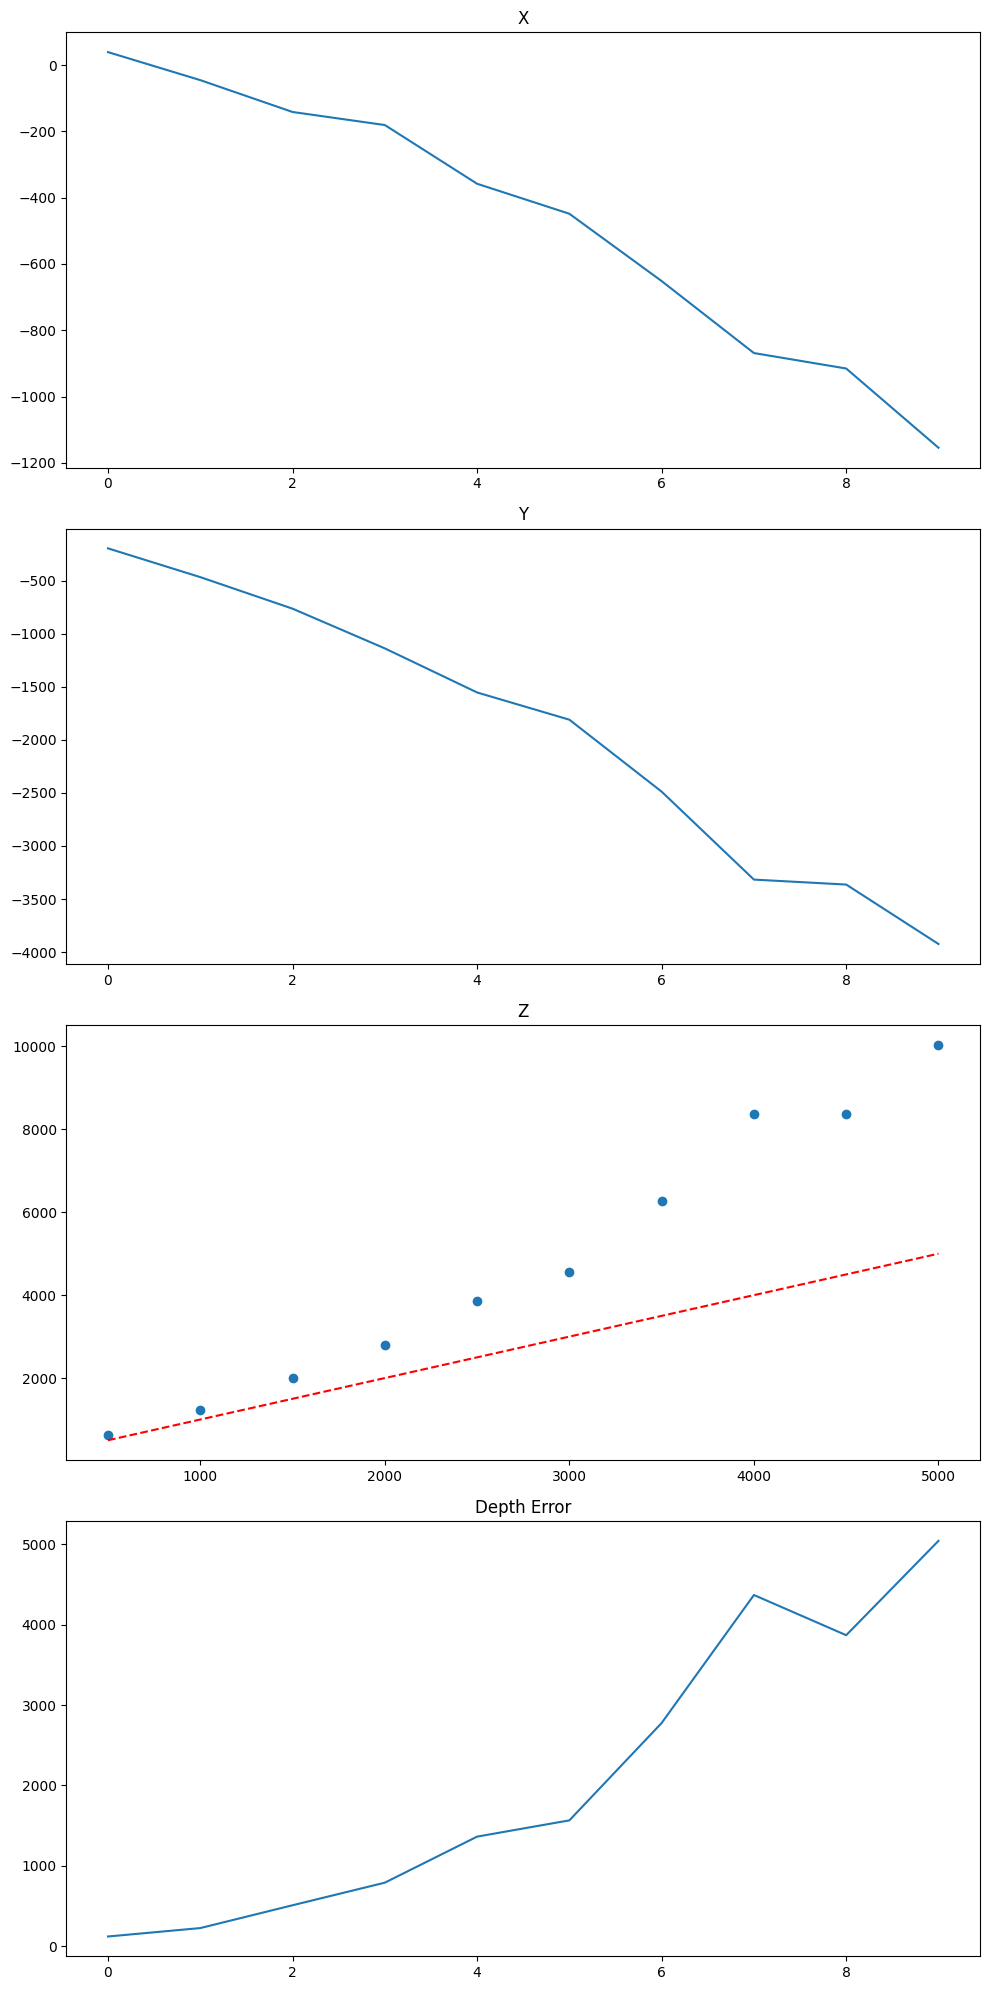

In [8]:
import matplotlib.pyplot as plt
#stereo2.py
f_x = calibration.f_x
f_y = calibration.f_y
f_skew = calibration.f_skew
o_x = calibration.o_x
o_y = calibration.o_y
"""stereo.py
K = calibration.K
f_x = K[0][0]
f_y = K[1][1]
f_skew = K[0][1]
o_x = K[0][2]
o_y = K[1][2]
"""
points_3d = []

def reconstruction(point1:list,point2:list,f_x=f_x,f_y=f_y,f_skew=f_skew, o_x=o_x, o_y=o_y,baseline=BASELINE)->list:
    """calculate 3d position
    Args:
      point1(list):2d position of left camera [t,x,y]
      point2(list):2d position of right camera [t,x,y]
    Return:
      (list):3d position
    """
    [x_1,y_1] = point1
    [x_2,y_2] = point2
    disparity = abs(x_1 - x_2)
    X = (baseline/disparity)*(x_1 - o_x - (f_skew/f_y)*(y_1 - o_y))
    Y = baseline * (f_x/f_y) * (y_1 - o_y)/disparity
    Z = (f_x * baseline)/disparity
    return [X,Y,Z]

Pos_3d = []
for i in range(len(Left)):
    pos = reconstruction(Left[i],Right[i])
    Pos_3d.append(pos)
Pos_3d = np.array(Pos_3d)

ref_pos = [i*500 for i in range(1,11)]
errors = []
for i in range(len(ref_pos)):
    error = abs(Pos_3d[i,2] - ref_pos[i])
    errors.append(error)
fig,ax = plt.subplots(4,1,figsize=(10,20),tight_layout = True)
ax[0].plot(Pos_3d[:,0])
ax[0].set_title("X")
ax[1].plot(Pos_3d[:,1])
ax[1].set_title("Y")
ax[2].plot(ref_pos,Pos_3d[:,2],marker="o",linewidth=0)
ax[2].plot(ref_pos,ref_pos,linestyle="--",color="r")
ax[2].set_title("Z")
ax[3].plot(errors)
ax[3].set_title("Depth Error")
fig.show()